In [2]:
import warnings
warnings.simplefilter('ignore')

#importing neccesary modules
import sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns

import sklearn
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
from sklearn.model_selection import GridSearchCV, train_test_split

import xgboost
from xgboost import XGBRegressor, DMatrix

In [3]:
#python package version information
print('Python version:{}'.format(sys.version))
print('Numpy version:{}'.format(np.__version__))
print('Pandas version:{}'.format(pd.__version__))
print('MatlpotLib version:{}'.format(matplotlib.__version__))
print('Seaborn version:{}'.format(sns.__version__))
print('Sci-Kit Learn version:{}'.format(sklearn.__version__))
print('XGBoost version:{}'.format(xgboost.__version__))

Python version:3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]
Numpy version:1.21.2
Pandas version:1.3.5
MatlpotLib version:3.5.0
Seaborn version:0.12.2
Sci-Kit Learn version:1.1.3
XGBoost version:1.7.3


In [4]:
eu = pd.read_csv('/Users/Mehrdadi/Downloads/eu.csv', index_col=0, parse_dates=True, skipinitialspace=True)
eu.drop('date', axis='columns', inplace=True)
eu.head(2)

,open,high,low,close,volume
1971-01-04,0.5369,0.5369,0.5369,0.5369,1
1971-01-05,0.5366,0.5366,0.5366,0.5366,1


In [5]:
eu.isna().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


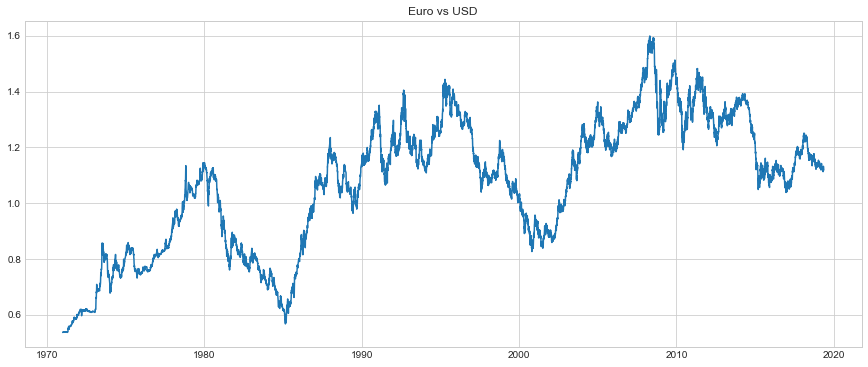

In [6]:
plt.figure(figsize=(15,6))
plt.plot(eu.close)
plt.title('Euro vs USD')
plt.legend()
plt.show()

<AxesSubplot:>

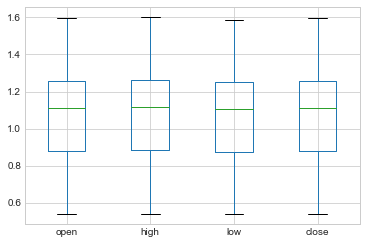

In [7]:
#box plot for open, high, low , close
eu.drop('volume', axis=1).boxplot()

In [8]:
#removing outliers above
vol_cut_off = eu.volume.std()*3 + eu.volume.mean()
eu.volume[eu.volume > vol_cut_off] = vol_cut_off

In [9]:
#removing ouliers below
vol_cut_off =  eu.volume.mean() - eu.volume.std()*3
eu.volume[eu.volume < vol_cut_off] = vol_cut_off

<AxesSubplot:>

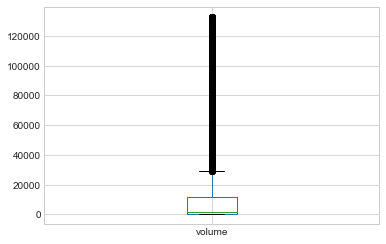

In [10]:
#boxplot for volume
eu[['volume']].boxplot()

In [15]:
def generate_features(df):
    """ Generate features for a stock/index/currency/commodity based on historical price and performance
    Args:
        df (dataframe with columns "open", "close", "high", "low", "volume")
    Returns:
        dataframe, data set with new features
    """
    df_new = pd.DataFrame()
    
    # 6 original features
    df_new['open'] = df['open']
    df_new['open_1'] = df['open'].shift(1)
    df_new['close_1'] = df['close'].shift(1)
    df_new['high_1'] = df['high'].shift(1)
    df_new['low_1'] = df['low'].shift(1)
    df_new['volume_1'] = df['volume'].shift(1)
    
    # 50 original features
    # average price
    df_new['avg_price_5'] = df['close'].rolling(window=5).mean().shift(1)
    df_new['avg_price_30'] = df['close'].rolling(window=21).mean().shift(1)
    df_new['avg_price_90'] = df['close'].rolling(window=63).mean().shift(1)
    df_new['avg_price_365'] = df['close'].rolling(window=252).mean().shift(1)
    
    # average price ratio
    df_new['ratio_avg_price_5_30'] = df_new['avg_price_5'] / df_new['avg_price_30']
    df_new['ratio_avg_price_905_'] = df_new['avg_price_5'] / df_new['avg_price_90']
    df_new['ratio_avg_price_5_365'] = df_new['avg_price_5'] / df_new['avg_price_365']
    df_new['ratio_avg_price_30_90'] = df_new['avg_price_30'] / df_new['avg_price_90']
    df_new['ratio_avg_price_30_365'] = df_new['avg_price_30'] / df_new['avg_price_365']
    df_new['ratio_avg_price_90_365'] = df_new['avg_price_90'] / df_new['avg_price_365']                                            
    
    
    # average volume
    df_new['avg_volume_5'] = df['volume'].rolling(window=5).mean().shift(1)
    df_new['avg_volume_30'] = df['volume'].rolling(window=21).mean().shift(1)
    df_new['avg_volume_90'] = df['volume'].rolling(window=63).mean().shift(1)
    df_new['avg_volume_365'] = df['volume'].rolling(window=252).mean().shift(1)
    
    #average volume ratio
    df_new['ratio_avg_volume_5_30'] = df_new['avg_volume_5'] / df_new['avg_volume_30']
    df_new['ratio_avg_volumee_5_90'] = df_new['avg_volume_5'] / df_new['avg_volume_90']                                                   
    df_new['ratio_avg_volume_5_365'] = df_new['avg_volume_5'] / df_new['avg_volume_365']
    df_new['ratio_avg_volume_30_90'] = df_new['avg_volume_30'] / df_new['avg_volume_90']
    df_new['ratio_avg_volume_30_365'] = df_new['avg_volume_30'] / df_new['avg_volume_365']
    df_new['ratio_avg_volume_90_365'] = df_new['avg_volume_90'] / df_new['avg_volume_365']                                                 
    
    
    # standard deviation of prices
    df_new['std_price_5'] = df['close'].rolling(window=5).std().shift(1)
    df_new['std_price_30'] = df['close'].rolling(window=21).std().shift(1)
    df_new['std_price_90'] = df['close'].rolling(window=63).std().shift(1)                                               
    df_new['std_price_365'] = df['close'].rolling(window=252).std().shift(1)
    
    # standard deviation ratio of prices 
    df_new['ratio_std_price_5_30'] = df_new['std_price_5'] / df_new['std_price_30']
    df_new['ratio_std_price_5_90'] = df_new['std_price_5'] / df_new['std_price_90']
    df_new['ratio_std_price_5_365'] = df_new['std_price_5'] / df_new['std_price_365']
    df_new['ratio_std_price_30_90'] = df_new['std_price_30'] / df_new['std_price_90'] 
    df_new['ratio_std_price_30_365'] = df_new['std_price_30'] / df_new['std_price_365']                                               
    df_new['ratio_std_price_90_365'] = df_new['std_price_90'] / df_new['std_price_365']                                                
    
    
    # standard deviation of volumes
    df_new['std_volume_5'] = df['volume'].rolling(window=5).std().shift(1)
    df_new['std_volume_30'] = df['volume'].rolling(window=21).std().shift(1)
    df_new['std_volume_90'] = df['volume'].rolling(window=63).std().shift(1)
    df_new['std_volume_365'] = df['volume'].rolling(window=252).std().shift(1)
    
    #standard deviation ratio of volumes
    df_new['ratio_std_volume_5_30'] = df_new['std_volume_5'] / df_new['std_volume_30']
    df_new['ratio_std_volume_5_90'] = df_new['std_volume_5'] / df_new['std_volume_90']
    df_new['ratio_std_volume_5_365'] = df_new['std_volume_5'] / df_new['std_volume_365']                                               
    df_new['ratio_std_volume_30_90'] = df_new['std_volume_30'] / df_new['std_volume_90']
    df_new['ratio_std_volume_30_365'] = df_new['std_volume_30'] / df_new['std_volume_365']
    df_new['ratio_std_volume_90_365'] = df_new['std_volume_90'] / df_new['std_volume_365']                                               
                                                   
    # return
    df_new['return_1'] = ((df['close'] - df['close'].shift(1)) / df['close'].shift(1)).shift(1)
    df_new['return_5'] = ((df['close'] - df['close'].shift(5)) / df['close'].shift(5)).shift(1)
    df_new['return_30'] = ((df['close'] - df['close'].shift(21)) / df['close'].shift(21)).shift(1)
    df_new['return_90'] = ((df['close'] - df['close'].shift(63)) / df['close'].shift(63)).shift(1)                                                
    df_new['return_365'] = ((df['close'] - df['close'].shift(252)) / df['close'].shift(252)).shift(1)
    
    #average of return
    df_new['moving_avg_5'] = df_new['return_1'].rolling(window=5).mean()
    df_new['moving_avg_30'] = df_new['return_1'].rolling(window=21).mean()
    df_new['moving_avg_30'] = df_new['return_1'].rolling(window=63).mean()
    df_new['moving_avg_365'] = df_new['return_1'].rolling(window=252).mean()
    
    # the target
    df_new['close'] = df['close']
    df_new = df_new.dropna(axis=0)
    return df_new

data = generate_features(eu)
data

,open,open_1,close_1,high_1,low_1,volume_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,...,ratio_std_volume_90_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_365,close
1972-05-24,0.61560,0.61540,0.61530,0.61540,0.61510,51.0,0.615020,0.615143,0.615479,0.588782,...,2.000000,0.000325,0.002281,-0.000812,0.000488,0.143043,0.000456,0.000027,0.000539,0.61560
1972-05-25,0.61470,0.61560,0.61560,0.61560,0.61560,1.0,0.615160,0.615152,0.615530,0.589088,...,2.000000,0.000488,0.001138,0.000325,0.005225,0.143388,0.000228,0.000102,0.000540,0.61470
1972-05-26,0.61530,0.61470,0.61470,0.61470,0.61470,1.0,0.615080,0.615133,0.615551,0.589391,...,2.000000,-0.001462,-0.000650,-0.000650,0.002119,0.141504,-0.000130,0.000053,0.000534,0.61530
1972-05-30,0.61590,0.61530,0.61530,0.61530,0.61530,1.0,0.615200,0.615129,0.615557,0.589695,...,2.000000,0.000976,0.000976,-0.000162,0.000651,0.142194,0.000196,0.000029,0.000536,0.61590
1972-05-31,0.61570,0.61590,0.61590,0.61590,0.61590,1.0,0.615360,0.615171,0.615573,0.589970,...,2.000000,0.000975,0.001301,0.001463,0.001626,0.126990,0.000260,0.000045,0.000482,0.61570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-01,1.12148,1.11841,1.12140,1.12286,1.11753,55570.0,1.116498,1.123167,1.128969,1.147996,...,0.540837,0.002575,-0.001087,0.000205,-0.020278,-0.053679,-0.000211,-0.000320,-0.000210,1.11941
2019-05-02,1.11942,1.12148,1.11941,1.12644,1.11867,52561.0,1.117332,1.123123,1.128558,1.147710,...,0.540557,-0.001775,0.003739,-0.000821,-0.022597,-0.060496,0.000749,-0.000358,-0.000239,1.11709
2019-05-03,1.11710,1.11942,1.11709,1.12187,1.11703,59203.0,1.118124,1.122836,1.128139,1.147404,...,0.540359,-0.002073,0.003558,-0.005369,-0.023096,-0.064547,0.000713,-0.000366,-0.000256,1.13234
2019-05-08,1.11922,1.11710,1.13234,1.13236,1.11346,62828.0,1.121752,1.123332,1.128010,1.147165,...,0.540711,0.013652,0.016281,0.009297,-0.007094,-0.050544,0.003251,-0.000107,-0.000197,1.11920


In [16]:
data.describe()

,open,open_1,close_1,high_1,low_1,volume_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,...,ratio_std_volume_90_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_365,close
count,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,...,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000
mean,1.086904,1.086862,1.086904,1.090896,1.082905,20154.319040,1.086818,1.086474,1.085562,1.081191,...,0.883381,0.000072,0.000362,0.001570,0.004863,0.021690,0.000072,0.000072,0.000078,1.086947
std,0.222026,0.222068,0.222061,0.224058,0.220081,35060.393836,0.222054,0.222072,0.222038,0.221877,...,0.330634,0.006479,0.014625,0.031592,0.057053,0.123511,0.002923,0.000903,0.000474,0.222019
min,0.567200,0.567200,0.567200,0.568600,0.563300,1.000000,0.574540,0.580143,0.601424,0.588782,...,0.044556,-0.056418,-0.095796,-0.147266,-0.200039,-0.325111,-0.019757,-0.003489,-0.001531,0.567200
25%,0.900500,0.900500,0.900500,0.904500,0.896400,291.000000,0.899380,0.901238,0.898514,0.895626,...,0.652543,-0.003369,-0.008254,-0.017748,-0.032792,-0.072561,-0.001642,-0.000510,-0.000279,0.900500
50%,1.118400,1.118350,1.118520,1.122400,1.114000,2071.000000,1.119028,1.117914,1.113101,1.110632,...,0.877178,0.000000,0.000157,0.000554,0.003428,0.014516,0.000042,0.000073,0.000079,1.118550
75%,1.263100,1.263100,1.263100,1.269200,1.256200,12393.000000,1.262906,1.263543,1.267203,1.254247,...,1.083265,0.003434,0.008752,0.020233,0.041597,0.097976,0.001761,0.000670,0.000392,1.263100
max,1.599500,1.599500,1.599700,1.603800,1.586600,132937.440396,1.591080,1.579900,1.564808,1.506541,...,2.000000,0.062078,0.106059,0.159589,0.245135,0.536577,0.020409,0.003513,0.001741,1.599700


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11781 entries, 1972-05-24 to 2019-05-09
Data columns (total 55 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   open                     11781 non-null  float64
 1   open_1                   11781 non-null  float64
 2   close_1                  11781 non-null  float64
 3   high_1                   11781 non-null  float64
 4   low_1                    11781 non-null  float64
 5   volume_1                 11781 non-null  float64
 6   avg_price_5              11781 non-null  float64
 7   avg_price_30             11781 non-null  float64
 8   avg_price_90             11781 non-null  float64
 9   avg_price_365            11781 non-null  float64
 10  ratio_avg_price_5_30     11781 non-null  float64
 11  ratio_avg_price_905_     11781 non-null  float64
 12  ratio_avg_price_5_365    11781 non-null  float64
 13  ratio_avg_price_30_90    11781 non-null  float64
 14  ratio

<AxesSubplot:>

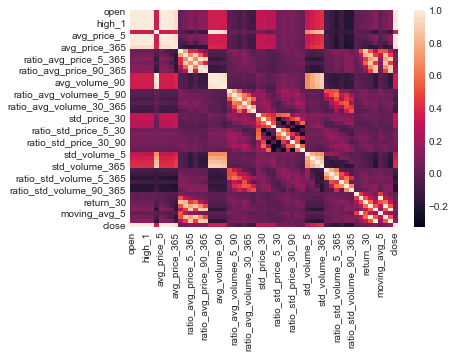

In [18]:
sns.heatmap(data.corr())

In [19]:
import datetime

#segregate data for training
start_train = datetime.datetime(1999, 1, 1,0,0)
end_train = datetime.datetime(2017, 12, 31, 0, 0)
data_train = data.loc[start_train:end_train]
data_train.describe()

,open,open_1,close_1,high_1,low_1,volume_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,...,ratio_std_volume_90_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_365,close
count,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,...,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000
mean,1.207845,1.207844,1.207882,1.213555,1.202155,40948.114379,1.207882,1.207862,1.207876,1.207394,...,0.816631,0.000020,0.000097,0.000457,0.001223,0.005686,0.000021,0.000019,0.000022,1.207885
std,0.172721,0.172721,0.172677,0.173244,0.172127,40535.398337,0.172545,0.172101,0.170867,0.164983,...,0.323131,0.006320,0.013728,0.028651,0.050264,0.101303,0.002745,0.000801,0.000400,0.172676
min,0.827200,0.827200,0.826700,0.832600,0.822700,1.000000,0.833560,0.849195,0.858429,0.883636,...,0.197396,-0.026604,-0.065191,-0.147266,-0.200039,-0.241870,-0.013307,-0.003489,-0.001086,0.826700
25%,1.086760,1.086760,1.086720,1.091700,1.080950,9051.000000,1.086860,1.086086,1.093687,1.102289,...,0.575167,-0.003710,-0.008580,-0.017528,-0.033266,-0.071921,-0.001699,-0.000515,-0.000276,1.086720
50%,1.232600,1.232600,1.232320,1.238200,1.226040,13905.000000,1.232142,1.230429,1.237444,1.240565,...,0.775851,0.000106,0.000234,-0.000177,0.003242,0.008982,0.000057,0.000072,0.000055,1.232320
75%,1.336200,1.336200,1.336200,1.341000,1.329910,69037.000000,1.335616,1.333619,1.330752,1.342692,...,1.015063,0.003518,0.009024,0.018390,0.035152,0.076301,0.001813,0.000565,0.000307,1.336200
max,1.599500,1.599500,1.599700,1.603800,1.586600,132937.440396,1.591080,1.579900,1.564808,1.506541,...,1.942073,0.034903,0.106059,0.141554,0.140802,0.260726,0.020409,0.002134,0.000938,1.599700


In [20]:
#segregate data for validation
start_test = datetime.datetime(2018, 1, 1, 0, 0)
end_test = datetime.datetime(2019, 6, 7, 0, 0)
data_test = data.loc[start_test:end_test]
data_test.describe()

,open,open_1,close_1,high_1,low_1,volume_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,...,ratio_std_volume_90_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_365,close
count,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,...,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000
mean,1.168335,1.168551,1.168404,1.172679,1.164774,85860.709055,1.168790,1.170189,1.173200,1.175544,...,0.785246,-0.000176,-0.000785,-0.002987,-0.007239,0.014224,-0.000156,-0.000114,0.000052,1.168174
std,0.038680,0.038614,0.038646,0.039068,0.038099,28427.264667,0.038265,0.036942,0.033194,0.017669,...,0.234142,0.004373,0.009027,0.016337,0.030892,0.086742,0.001806,0.000491,0.000332,0.038700
min,1.113220,1.113220,1.113130,1.116200,1.111050,698.000000,1.116498,1.122836,1.127743,1.131791,...,0.430578,-0.019107,-0.022843,-0.046899,-0.067556,-0.094090,-0.004603,-0.001100,-0.000383,1.113130
25%,1.136580,1.136750,1.136570,1.140910,1.133530,64344.000000,1.136546,1.137379,1.139820,1.161746,...,0.569664,-0.002896,-0.007221,-0.011647,-0.025809,-0.054522,-0.001444,-0.000410,-0.000213,1.136550
50%,1.158720,1.158740,1.159300,1.162750,1.154300,79792.000000,1.161040,1.162870,1.162962,1.181830,...,0.757015,-0.000070,-0.001085,-0.003310,-0.011099,-0.017814,-0.000203,-0.000170,-0.000062,1.158770
75%,1.195030,1.195030,1.195030,1.200880,1.192600,107336.000000,1.197898,1.198645,1.202718,1.190621,...,0.953143,0.002727,0.005213,0.004623,0.005808,0.100285,0.001050,0.000101,0.000389,1.194740
max,1.250730,1.250730,1.250780,1.255540,1.244800,132937.440396,1.243208,1.237799,1.234132,1.195315,...,1.303164,0.014013,0.027068,0.045857,0.073182,0.185276,0.005369,0.001130,0.000685,1.250780


In [21]:
X_train = data_train.drop('close', axis='columns')
y_train = data_train.close

X_test = data_test.drop('close', axis='columns')
y_test = data_test.close

#checking the shape of the train and test data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4941, 54), (349, 54), (4941,), (349,))

In [22]:
#initiating standard scaler
scaler = StandardScaler()

#fit the scaler in training features
scaler.fit(X_train)

#Rescale both sets using the trained scaler
X_scaled_train = scaler.transform(X_train)
X_scaled_test = scaler.transform(X_test)

In [23]:
from sklearn.linear_model import LinearRegression
lin = LinearRegression()

lin.fit(X_scaled_train, y_train)
predictions_lin = lin.predict(X_scaled_test)

print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_lin)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_lin)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_lin)))

RMSE: 0.005
MAE: 0.004
R^2: 0.983


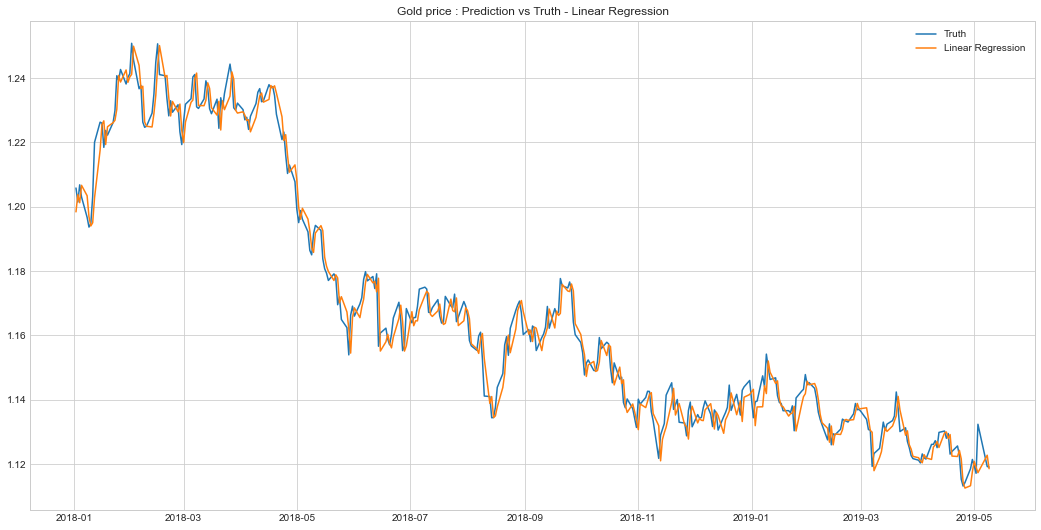

In [24]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plt.style.use('seaborn-whitegrid')
plot_truth, = plt.plot(dates, y_test)
plot_lin, = plt.plot(dates, predictions_lin)
plt.legend([plot_truth, plot_lin], ['Truth', 'Linear Regression'])
plt.title('Gold price : Prediction vs Truth - Linear Regression')
plt.show()

In [25]:
from sklearn.linear_model import SGDRegressor

param_grid = {
    'penalty':['l1', 'l2', 'elasticnet'],
    "alpha": [1e-5, 3e-5, 1e-4],
    "eta0": [0.01, 0.03, 0.1],
}

sgd = SGDRegressor()
grid_search = GridSearchCV(sgd, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_scaled_train, y_train)

print(grid_search.best_params_)

sgd_best = grid_search.best_estimator_
#print(grid_search.best_score_)

predictions_sgd = sgd_best.predict(X_scaled_test)

#evaluating the predictions
print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_sgd)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_sgd)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_sgd)))

{'alpha': 0.0001, 'eta0': 0.03, 'penalty': 'l1'}
RMSE: 0.006
MAE: 0.004
R^2: 0.978


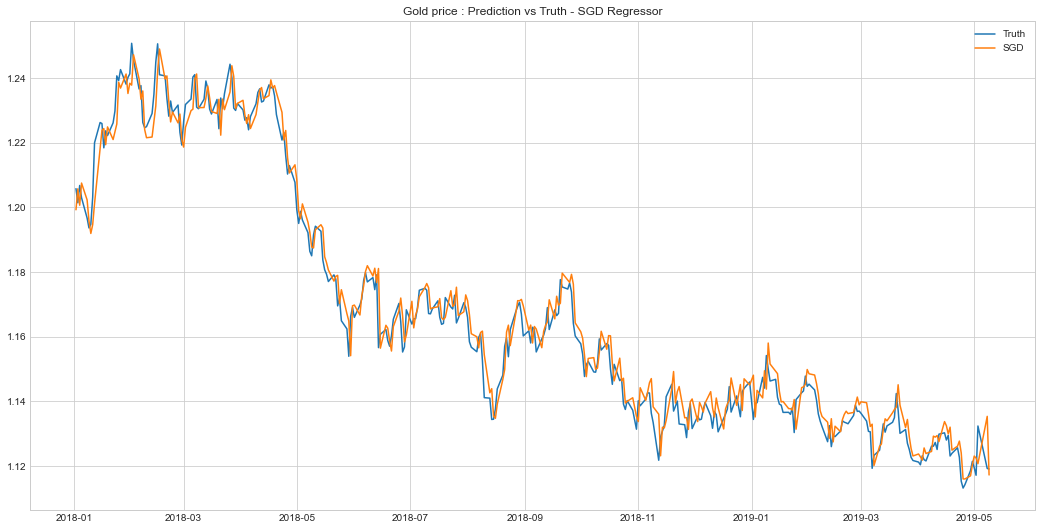

In [26]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_sgd, = plt.plot(dates, predictions_sgd)
plt.legend([plot_truth, plot_sgd], ['Truth', 'SGD'])
plt.title('Gold price : Prediction vs Truth - SGD Regressor')
plt.style.use('seaborn-whitegrid')
plt.show()

In [27]:
xgb = XGBRegressor()

data_dmatrix = DMatrix(data=X_train,
                           label=y_train)

xgb_param_grid = {'learning_rate': [0.001, 0.01, 0.1, 1],
                  'n_estimators': [50, 100, 200, 300],
                  'subsample': [0.3, 0.5, 0.7, 1]}

grid_search = GridSearchCV(estimator=xgb,    
                        param_grid=xgb_param_grid,
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                       n_jobs=-1)

grid_search.fit(X_train, y_train) 

print("Best parameters found: ",grid_search.best_params_)

xgb_best = grid_search.best_estimator_

xgb_best.fit(X_train,y_train)
predictions_xgb = xgb_best.predict(X_test)

print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_xgb)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_xgb)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_xgb)))

Fitting 4 folds for each of 64 candidates, totalling 256 fits
Best parameters found:  {'learning_rate': 0.1, 'n_estimators': 50, 'subsample': 1}
RMSE: 0.007
MAE: 0.006
R^2: 0.966


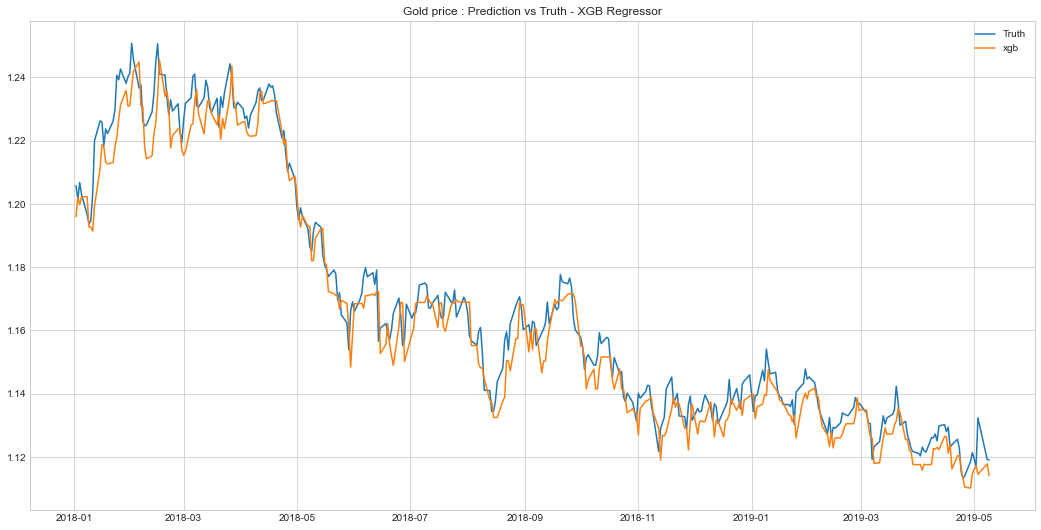

In [28]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_xgb, = plt.plot(dates, predictions_xgb)
plt.legend([plot_truth, plot_xgb], ['Truth', 'xgb'])
plt.title('Gold price : Prediction vs Truth - XGB Regressor')
plt.show()

In [29]:
bgr = BaggingRegressor(base_estimator=lin, n_estimators=100, oob_score=True, n_jobs=-1)

bgr.fit(X_scaled_train, y_train)
predictions_bgr = bgr.predict(X_scaled_test)

print('OOB: {0:.3f}'.format(bgr.oob_score))
print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_bgr)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_bgr)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_bgr)))

OOB: 1.000
RMSE: 0.005
MAE: 0.004
R^2: 0.983


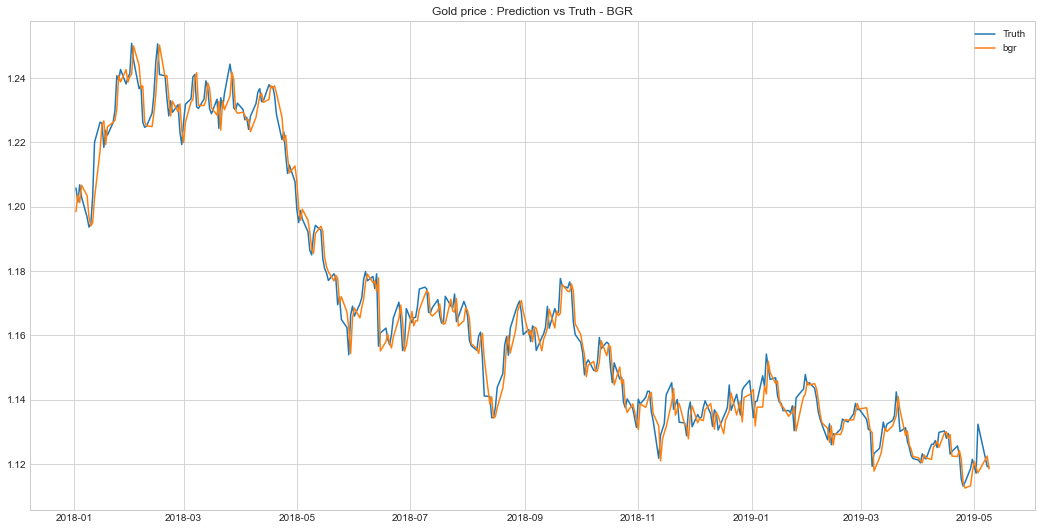

In [30]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_bgr, = plt.plot(dates, predictions_bgr)
plt.legend([plot_truth, plot_bgr], ['Truth', 'bgr'])
plt.title('Gold price : Prediction vs Truth - BGR')
plt.show()